**Параметры RNN, полученные при решении задачи: https://drive.google.com/file/d/1A7FjfYfX6ALgZB1Sqv1-6GrwXSrknrsx/view?usp=sharing**

In [ ]:
!pip install optuna -q
!pip install catboost -q
!pip install accelerate -q

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#KNN" data-toc-modified-id="KNN-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.0.4"><span class="toc-item-num">3.0.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.0.5"><span class="toc-item-num">3.0.5&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#Classic-NN" data-toc-modified-id="Classic-NN-3.0.6"><span class="toc-item-num">3.0.6&nbsp;&nbsp;</span>Classic NN</a></span></li><li><span><a href="#Classical-NN-+-Early-Stopping" data-toc-modified-id="Classical-NN-+-Early-Stopping-3.0.7"><span class="toc-item-num">3.0.7&nbsp;&nbsp;</span>Classical NN + Early Stopping</a></span></li><li><span><a href="#RNN" data-toc-modified-id="RNN-3.0.8"><span class="toc-item-num">3.0.8&nbsp;&nbsp;</span>RNN</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.0.9"><span class="toc-item-num">3.0.9&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Проект: прогноз числа заказов такси на следующий час (RMSE ≤ 48)

План:

Данные: загрузить taxi.csv, переформатировать метку времени и сделать hourly resample.

EDA: посмотреть тренды/сезонность, убрать аномалии и пропуски.

Фичи: час суток, день недели, лаги (1–3 ч), скользящее среднее (3–24 ч).

Выборки: последние 10 % по времени — тест, остальные — обучение + CV.

Модели: LightGBM/RandomForest + подбор гиперпараметров; проверка на тесте по RMSE.

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.tree import DecisionTreeRegressor
import catboost
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch
from sklearn.preprocessing import StandardScaler
import tqdm
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
try:
    df = pd.read_csv('/kaggle/input/taxi-sth/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
data = df.resample('1H').sum()

/tmp/ipykernel_34/1520849101.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = df.resample('1H').sum()


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Для начала посмотрим на сам график:

<Axes: xlabel='datetime'>

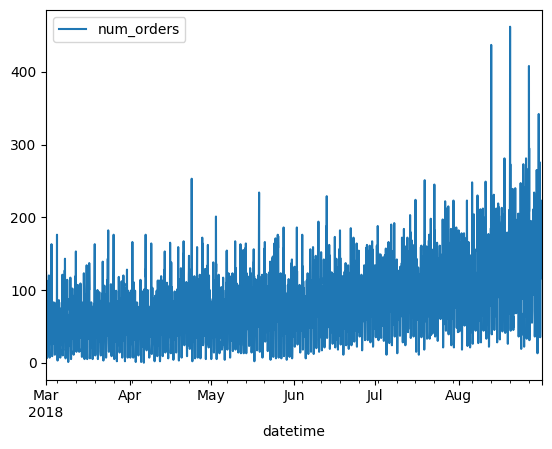

In [ ]:
data.plot()

На графике виден некоторый тренд на увеличение количества заказов, но для этого рассматрим этот тренд подробнее:

In [ ]:
decomposed = seasonal_decompose(data)


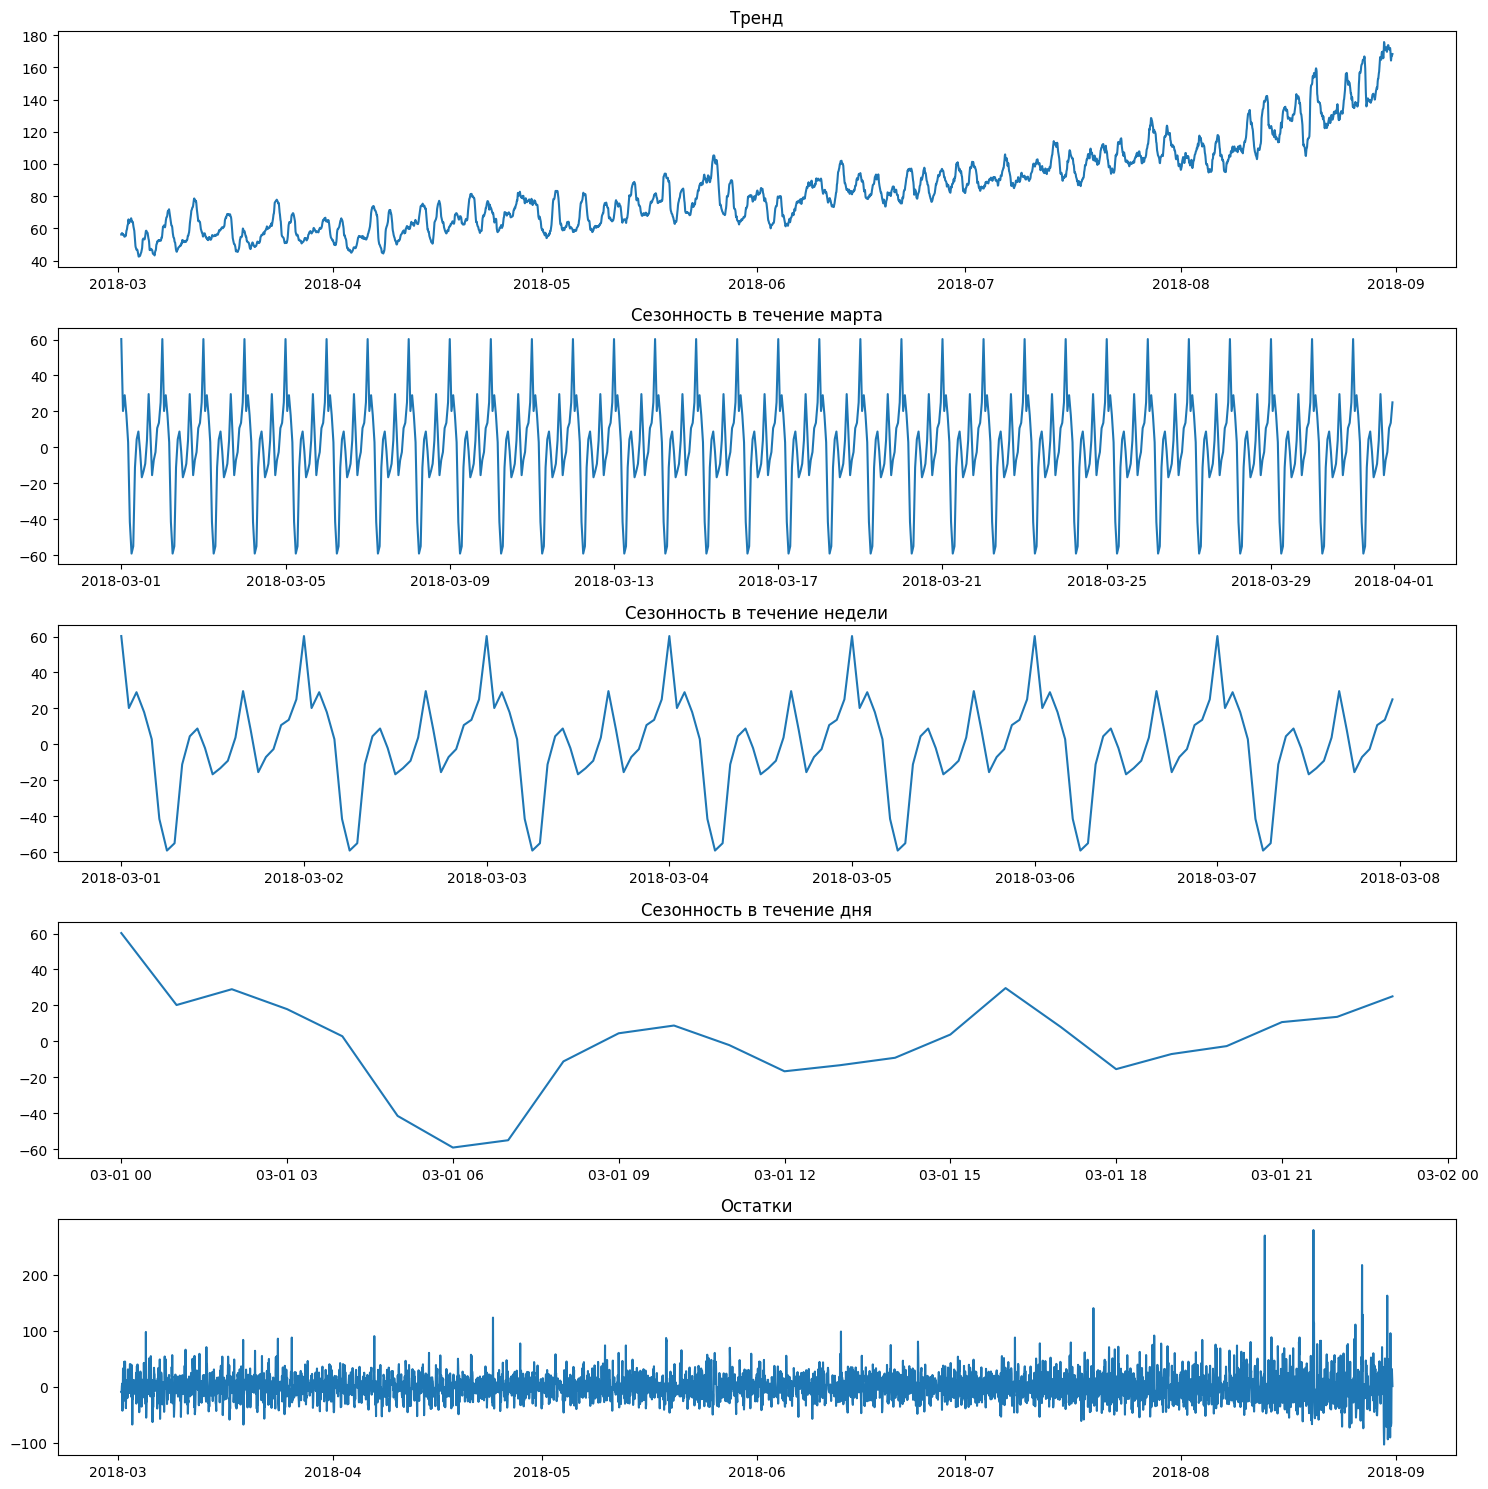

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].plot(decomposed.trend)
axes[0].set_title('Тренд')

axes[1].plot(decomposed.seasonal['2018-03']) # за март
axes[1].set_title('Сезонность в течение марта')

axes[2].plot(decomposed.seasonal.iloc[:168]) # 168 часов это одна неделя, посмотрим за нее.
axes[2].set_title('Сезонность в течение недели')

axes[3].plot(decomposed.seasonal.iloc[:24]) # 24 часа это день, посмотрим за него.
axes[3].set_title('Сезонность в течение дня')

axes[4].plot(decomposed.resid)
axes[4].set_title('Остатки')

plt.tight_layout()
plt.show()

На графиках видно, что со временем растет количество заказов. Также бросается в глаза сезонность, как видим день ото дня происходят регулярные колебания, которые можно объяснить растущим спросом в опредленные часы дня. Шум выглядит довольно рандомизированным, что является плюсом.

Теперь создадим новые признаки.

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    return data

Признак с годом выглядит довольно бесполезным, учитывая, что данные у нас только за 2018 год, но оставим его в случае использования других датасетов за другие года.

In [ ]:
df = make_features(data, 24, 4)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   year          4416 non-null   int32  
 2   month         4416 non-null   int32  
 3   day           4416 non-null   int32  
 4   dayofweek     4416 non-null   int32  
 5   hour          4416 non-null   int32  
 6   lag_1         4415 non-null   float64
 7   lag_2         4414 non-null   float64
 8   lag_3         4413 non-null   float64
 9   lag_4         4412 non-null   float64
 10  lag_5         4411 non-null   float64
 11  lag_6         4410 non-null   float64
 12  lag_7         4409 non-null   float64
 13  lag_8         4408 non-null   float64
 14  lag_9         4407 non-null   float64
 15  lag_10        4406 non-null   float64
 16  lag_11        4405 non-null   float64
 17  lag_12        4404 non-null

In [ ]:
df = df.dropna()

In [ ]:
df

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2018,3,2,4,0,58.0,113.0,66.0,61.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,74.50
2018-03-02 01:00:00,120,2018,3,2,4,1,90.0,58.0,113.0,66.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,81.75
2018-03-02 02:00:00,75,2018,3,2,4,2,120.0,90.0,58.0,113.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,95.25
2018-03-02 03:00:00,64,2018,3,2,4,3,75.0,120.0,90.0,58.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,85.75
2018-03-02 04:00:00,20,2018,3,2,4,4,64.0,75.0,120.0,90.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,87.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,19,207.0,217.0,197.0,116.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,184.25
2018-08-31 20:00:00,154,2018,8,31,4,20,136.0,207.0,217.0,197.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,189.25
2018-08-31 21:00:00,159,2018,8,31,4,21,154.0,136.0,207.0,217.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,178.50


In [ ]:
y = df['num_orders']
X = df.drop(columns=['num_orders'])

train_data, test_data = train_test_split(data, shuffle=False, random_state=32, test_size=0.1)
train_data, valid_data = train_test_split(train_data, shuffle=False, random_state=32, test_size=0.1)



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=32, test_size=0.1)

In [ ]:
train_data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-07-27 19:00:00,86
2018-07-27 20:00:00,131
2018-07-27 21:00:00,133


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, shuffle=False, random_state=32, test_size=0.1)

In [ ]:
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_valid_norm = sc.transform(X_valid)
X_test_norm = sc.transform(X_test)

#### Вывод
Некие тенденции есть, тренд растет, сезонность в течение недели есть. Шум выглядит довольно случайным.

## Обучение

Для начала построим простые модели и посмотрим как они будут справляться с задачей:

#### KNN

In [ ]:
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 100)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 1, 100)
    p = trial.suggest_float('p', 1, 10)
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan'])

    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm,
                                leaf_size=leaf_size, p=p, metric=metric, n_jobs=-1)
    model.fit(X_train, y_train)

    rmse = np.sqrt(mean_squared_error(model.predict(X_valid), y_valid))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)

study.best_params

[I 2024-02-10 08:46:31,617] A new study created in memory with name: no-name-b72c0333-b32b-40f2-b173-49031cf5398c
[I 2024-02-10 08:46:32,163] Trial 0 finished with value: 37.891318741382264 and parameters: {'n_neighbors': 94, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 62, 'p': 2.5001971015434963, 'metric': 'minkowski'}. Best is trial 0 with value: 37.891318741382264.
[I 2024-02-10 08:46:32,184] Trial 1 finished with value: 33.835964220744096 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 94, 'p': 5.970059340605713, 'metric': 'euclidean'}. Best is trial 1 with value: 33.835964220744096.
[I 2024-02-10 08:46:32,564] Trial 2 finished with value: 39.4166963606641 and parameters: {'n_neighbors': 86, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 74, 'p': 5.8498828549525275, 'metric': 'minkowski'}. Best is trial 1 with value: 33.835964220744096.
[I 2024-02-10 08:46:32,602] Trial 3 finished with value: 34.116391202386026 and p

{'n_neighbors': 7,
 'weights': 'distance',
 'algorithm': 'ball_tree',
 'leaf_size': 84,
 'p': 7.617288636493358,
 'metric': 'euclidean'}

In [ ]:
knn_prm = {'n_neighbors': 7,
 'weights': 'distance',
 'algorithm': 'ball_tree',
 'leaf_size': 84,
 'p': 7.617288636493358,
 'metric': 'euclidean'}

model_knn = KNeighborsRegressor(**knn_prm)
model_knn.fit(X_train, y_train)
knn_pred = model_knn.predict(X_valid)
np.sqrt(mean_squared_error(knn_pred, y_valid))

33.35089171409601

Как видим задачу на валидации мы уже решаем тем самым, так как главное условие RMSE < 48, но давайте проверим другие модели и то, как они будут справляться с задачей.

#### Линейная регрессия

Здесь как таковых гиперпараметров нет, так что просто обучим ее.

In [ ]:
model_linear = LinearRegression(n_jobs=-1)
model_linear.fit(X_train_norm, y_train)
linear_pred = model_linear.predict(X_valid_norm)
np.sqrt(mean_squared_error(linear_pred, y_valid))

34.199257743128506

Здесь получили результат чуть хуже чем был у KNN, но все равно хорошо. Пора переходить к более сложным моделям.

#### Решающее дерево

In [ ]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 1, 200, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 1000, log=True)
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 1)
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.0, 1)

    model = DecisionTreeRegressor(criterion=criterion, splitter=splitter, max_depth=max_depth,
                                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                  min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features,
                                  random_state=13, max_leaf_nodes=max_leaf_nodes,
                                  min_impurity_decrease=min_impurity_decrease, ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    rmse = mean_squared_error(model.predict(X_valid), y_valid)
    return np.sqrt(rmse)


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)

study.best_params

[I 2024-02-10 08:47:56,636] A new study created in memory with name: no-name-2861185b-f82a-4568-bdee-0d794bcb9663
[I 2024-02-10 08:47:56,662] Trial 0 finished with value: 59.12098108151119 and parameters: {'criterion': 'absolute_error', 'splitter': 'random', 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 19, 'min_weight_fraction_leaf': 0.3134535293596264, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.34356323335603534, 'ccp_alpha': 0.6399139697240847}. Best is trial 0 with value: 59.12098108151119.
[I 2024-02-10 08:47:56,672] Trial 1 finished with value: 48.02602327343653 and parameters: {'criterion': 'friedman_mse', 'splitter': 'best', 'max_depth': 69, 'min_samples_split': 11, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.36270362966178277, 'max_features': 'log2', 'max_leaf_nodes': 3, 'min_impurity_decrease': 0.8787598351902278, 'ccp_alpha': 0.8046685215056351}. Best is trial 1 with value: 48.02602327343653.
[I 2024-02-10 08:47:56,682] T

{'criterion': 'squared_error',
 'splitter': 'best',
 'max_depth': 41,
 'min_samples_split': 26,
 'min_samples_leaf': 9,
 'min_weight_fraction_leaf': 0.0010561201207747713,
 'max_features': 'log2',
 'max_leaf_nodes': 207,
 'min_impurity_decrease': 0.789210287196314,
 'ccp_alpha': 0.05238016406071961}

In [ ]:
dtc_prm = {'criterion': 'squared_error',
 'splitter': 'best',
 'max_depth': 41,
 'min_samples_split': 26,
 'min_samples_leaf': 9,
 'min_weight_fraction_leaf': 0.0010561201207747713,
 'max_features': 'log2',
 'max_leaf_nodes': 207,
 'min_impurity_decrease': 0.789210287196314,
 'ccp_alpha': 0.05238016406071961}

dtc_model = DecisionTreeRegressor(**dtc_prm, random_state=13)
dtc_model.fit(X_train, y_train)
dtc_pred = dtc_model.predict(X_valid)
np.sqrt(mean_squared_error(dtc_pred, y_valid))

36.06323769878015

А здесь прогноз чуть хуже чем у предыдущих более простых моделей.

#### Случайный лес


In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])
    max_depth = trial.suggest_int('max_depth', 1, 100, log=True)
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.5)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.5)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0, 0.5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    n_jobs = -1
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 1000, log=True)
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 1)
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.0, 1)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        n_jobs=n_jobs,
        random_state=13,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        ccp_alpha=ccp_alpha
    )
    model.fit(X_train, y_train)
    rmse = mean_squared_error(model.predict(X_valid), y_valid)
    return np.sqrt(rmse)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

study.best_params

[I 2024-02-10 08:49:03,990] A new study created in memory with name: no-name-15f43eba-bd65-4948-9c43-ece8ce57f684
[I 2024-02-10 08:49:05,274] Trial 0 finished with value: 57.97059672908483 and parameters: {'n_estimators': 517, 'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 0.21537970771802417, 'min_samples_leaf': 0.40576704269726394, 'min_weight_fraction_leaf': 0.44202175810848837, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.22031036153047034, 'ccp_alpha': 0.9175459625996841}. Best is trial 0 with value: 57.97059672908483.
[I 2024-02-10 08:49:07,320] Trial 1 finished with value: 57.95762422379686 and parameters: {'n_estimators': 796, 'criterion': 'poisson', 'max_depth': 30, 'min_samples_split': 0.2436187415855388, 'min_samples_leaf': 0.43202445017221136, 'min_weight_fraction_leaf': 0.4992680275056579, 'max_features': 'log2', 'max_leaf_nodes': 15, 'min_impurity_decrease': 0.3238297101425355, 'ccp_alpha': 0.6562466070715341}. Best is tria

{'n_estimators': 665,
 'criterion': 'squared_error',
 'max_depth': 7,
 'min_samples_split': 0.10166160579986933,
 'min_samples_leaf': 0.01021780460414519,
 'min_weight_fraction_leaf': 0.09396095446205793,
 'max_features': None,
 'max_leaf_nodes': 745,
 'min_impurity_decrease': 0.08841961917851453,
 'ccp_alpha': 0.23929619731029178}

In [ ]:
rfc_prm = {'n_estimators': 665,
 'criterion': 'squared_error',
 'max_depth': 7,
 'min_samples_split': 0.10166160579986933,
 'min_samples_leaf': 0.01021780460414519,
 'min_weight_fraction_leaf': 0.09396095446205793,
 'max_features': None,
 'max_leaf_nodes': 745,
 'min_impurity_decrease': 0.08841961917851453,
 'ccp_alpha': 0.23929619731029178}

rfc_model = RandomForestRegressor(**rfc_prm, random_state=13)
rfc_model.fit(X_train, y_train)
rfc_pred = rfc_model.predict(X_valid)
np.sqrt(mean_squared_error(rfc_pred, y_valid))


40.72416259705381

А вот здесь уже начались проблемы, модель не смогла и близко дойти до результатов более простых моделей.

#### Градиентный бустинг

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'random_strength': trial.suggest_int('random_strength', 1, 50),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 5, 255),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0),
        'loss_function': 'RMSE',
        'verbose': False
    }
    model = catboost.CatBoostRegressor(**params, random_state=13, task_type='GPU')
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)
    return np.sqrt(mean_squared_error(model.predict(X_valid), y_valid))


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

study.best_params

[I 2024-02-10 09:53:33,012] A new study created in memory with name: no-name-79bb9a99-5ca6-4f71-8e50-8cbb7260d4a3
[I 2024-02-10 09:54:44,340] Trial 0 finished with value: 33.79170425347731 and parameters: {'iterations': 915, 'depth': 14, 'learning_rate': 0.7028026171627211, 'random_strength': 25, 'bagging_temperature': 0.10882726982490643, 'border_count': 211, 'l2_leaf_reg': 4.925016467428138}. Best is trial 0 with value: 33.79170425347731.
[I 2024-02-10 09:54:46,480] Trial 1 finished with value: 34.86438422195987 and parameters: {'iterations': 113, 'depth': 10, 'learning_rate': 0.7669990629437542, 'random_strength': 20, 'bagging_temperature': 0.37956850658660857, 'border_count': 89, 'l2_leaf_reg': 1.3849987895412825}. Best is trial 0 with value: 33.79170425347731.
[I 2024-02-10 09:54:48,788] Trial 2 finished with value: 33.30478939067521 and parameters: {'iterations': 327, 'depth': 10, 'learning_rate': 0.6665449468655064, 'random_strength': 13, 'bagging_temperature': 0.636347621166560

{'iterations': 799,
 'depth': 8,
 'learning_rate': 0.05871081645038923,
 'random_strength': 12,
 'bagging_temperature': 0.7105458170796254,
 'border_count': 39,
 'l2_leaf_reg': 1.8605390642161002}

In [ ]:
cbr_prm = {'iterations': 799,
 'depth': 8,
 'learning_rate': 0.05871081645038923,
 'random_strength': 12,
 'bagging_temperature': 0.7105458170796254,
 'border_count': 39,
 'l2_leaf_reg': 1.8605390642161002}

cbr_model = catboost.CatBoostRegressor(**cbr_prm, random_state=13, verbose=False)
cbr_model.fit(X_train, y_train)
cbr_pred = cbr_model.predict(X_valid)
np.sqrt(mean_squared_error(cbr_pred, y_valid))

31.321304021163723

Лучший результат из всех имеющихся, теперь проверим нейронные сети.

#### Classic NN

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [ ]:
X_tr = torch.FloatTensor(X_train_norm)
X_val = torch.FloatTensor(X_valid_norm)
y_tn = torch.FloatTensor(y_train.values)
y_vd = torch.FloatTensor(y_valid.values)
X_t = torch.FloatTensor(X_test_norm)
y_tt = torch.FloatTensor(y_test.values)




train_set = TensorDataset(X_tr, y_tn)
val_set = TensorDataset(X_val, y_vd)
test_set = TensorDataset(X_t, y_tt)


batch_size = 4
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)



In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.Dropout(0.2)
        self.act1 = Swish()
        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.Dropout(0.2)
        self.act2 = Swish()

        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.act1(self.bn1(self.layer1(x)))
        x = self.act2(self.bn2(self.layer2(x)))
        x = self.layer3(x)
        return x




In [ ]:
def train_model(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, sched=None):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        loss_sum = 0

        for x_b, y_b in tqdm.tqdm(train_loader):
            x_b, y_b = x_b.to(device), y_b.to(device)
            optimizer.zero_grad()
            preds_train = model(x_b)
            loss_train = torch.sqrt(loss_fn(preds_train.reshape(-1), y_b))
            loss_sum += loss_train.item()
            loss_train.backward()
            optimizer.step()
        train_losses.append(loss_sum / len(train_loader))
        model.eval()
        loss_sum = 0
        with torch.no_grad():
            for x_b, y_b in tqdm.tqdm(val_loader):
                x_b, y_b = x_b.to(device), y_b.to(device)
                preds_val = model(x_b)
                loss_sum += torch.sqrt(loss_fn(preds_val.reshape(-1), y_b)).item()

        val_losses.append(loss_sum / len(val_loader))
        if sched != None:
            sched.step()


    return train_losses, val_losses


In [ ]:
input_dim = 30
model = Model(input_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)
train_losses, val_losses = train_model(model, optimizer, loss_fn, train_loader, val_loader, num_epochs)



100%|██████████| 99/99 [00:00<00:00, 1929.65it/s]


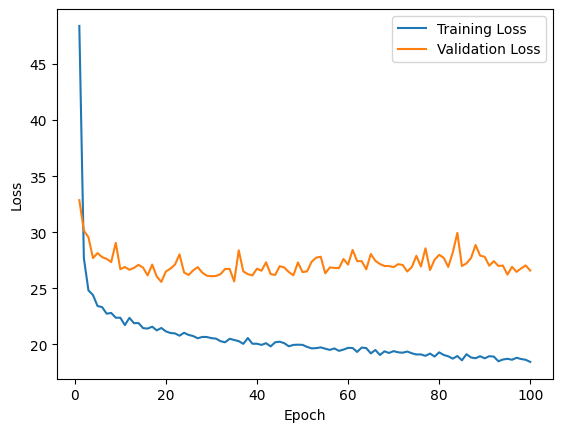

In [ ]:
train_losses_np = [float(loss) for loss in train_losses]
val_losses_np = [float(loss) for loss in val_losses]

plt.plot(range(1, num_epochs + 1), train_losses_np, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_np, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
nn_model = model

In [ ]:
with torch.no_grad():
    y_val_pred = nn_model(X_val.to(device)).cpu().numpy()
nn_pred = y_val_pred
np.sqrt(mean_squared_error(y_val_pred, y_valid))




30.609859064094483

Получили лучший результат по метрике

#### Classical NN + Early Stopping

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 96)
        self.bn1 = nn.Dropout(0.2)
        self.act1 = nn.LeakyReLU()
        self.layer2 = nn.Linear(96, 64)
        self.bn2 = nn.Dropout(0.2)
        self.act2 = Swish()

        self.layer3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.act1(self.bn1(self.layer1(x)))
        x = self.act2(self.bn2(self.layer2(x)))
        x = self.layer3(x)
        return x




In [ ]:
def train_model(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, sched=None, early_stopping_patience=None):
    train_losses = []
    val_losses = []
    p_counter = 0
    best_val_score = 1e5
    last_epoch = 1
    best_epoch = 0
    for epoch in range(num_epochs):
        last_epoch += 1
        model.train()
        loss_sum = 0

        for x_b, y_b in tqdm.tqdm(train_loader):
            x_b, y_b = x_b.to(device), y_b.to(device)
            optimizer.zero_grad()
            preds_train = model(x_b)
            loss_train = torch.sqrt(loss_fn(preds_train.reshape(-1), y_b))
            loss_sum += loss_train.item()
            loss_train.backward()
            optimizer.step()
        train_losses.append(loss_sum / len(train_loader))
        model.eval()
        loss_sum = 0
        with torch.no_grad():
            for x_b, y_b in tqdm.tqdm(val_loader):
                x_b, y_b = x_b.to(device), y_b.to(device)
                preds_val = model(x_b)
                loss_sum += torch.sqrt(loss_fn(preds_val.reshape(-1), y_b)).item()
        val_loss = loss_sum / len(val_loader)
        val_losses.append(val_loss)
        if early_stopping_patience is not None:
            if val_loss < best_val_score:
                best_val_score = val_loss
                p_counter = 0
                best_epoch = epoch
            else:
                p_counter += 1
                if p_counter >  early_stopping_patience:
                    print('Early stop break')
                    break
        if sched != None:
            sched.step()



    return train_losses, val_losses, last_epoch, best_epoch



In [ ]:
input_dim = 30
model = Model(input_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr= 5 * 1e-2)
loss_fn = nn.MSELoss()


num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)
train_losses, val_losses, last_epoch, best_epoch = train_model(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, scheduler, 20)


100%|██████████| 99/99 [00:00<00:00, 1946.47it/s]

Early stop break


In [ ]:
best_epoch

6

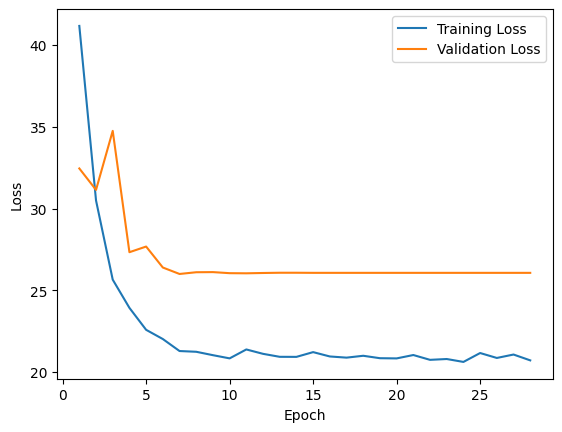

In [ ]:
plt.plot(range(1, last_epoch), train_losses, label='Training Loss')
plt.plot(range(1, last_epoch), val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
input_dim = 30
model = Model(input_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr= 5 * 1e-2)
loss_fn = nn.MSELoss()


num_epochs = 6
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)
train_losses, val_losses, last_epoch, best_epoch = train_model(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, scheduler, 20)


100%|██████████| 99/99 [00:00<00:00, 2012.50it/s]


In [ ]:
esnn_model = model
with torch.no_grad():
    y_val_pred = esnn_model(X_val.to(device)).cpu().numpy()
esnn_pred = y_val_pred
np.sqrt(mean_squared_error(esnn_pred, y_valid))




30.559601231267322

Получили пока что лучший результат из имеющихся.

#### RNN

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [ ]:
def create_dataset(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 24

X_train_rnn, y_train_rnn = create_dataset(train_data.to_numpy().flatten(), sequence_length)
X_valid_rnn, y_valid_rnn = create_dataset(valid_data.to_numpy().flatten(), sequence_length)
X_test_rnn, y_test_rnn = create_dataset(test_data.to_numpy().flatten(), sequence_length)



In [ ]:

X_train_tensor = torch.Tensor(X_train_rnn).unsqueeze(-1)
y_train_tensor = torch.Tensor(y_train_rnn)
X_valid_tensor = torch.Tensor(X_valid_rnn).unsqueeze(-1)
y_valid_tensor = torch.Tensor(y_valid_rnn)


X_test_tensor = torch.Tensor(X_test_rnn).unsqueeze(-1)
y_test_tensor = torch.Tensor(y_test_rnn)

batch_size = 4


In [ ]:
X_train.shape

(3556, 30)

In [ ]:
class TaxiRNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, num_layers, output_size):
        super(TaxiRNN, self).__init__()
        self.hidden_size = hidden_size_1
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size_1, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size_1, hidden_size_2)
#         self.bn1 = nn.Dropout1d(hidden_size_1)
#         self.act1 = Swish()
        self.fc2 = nn.Linear(hidden_size_2, output_size)
#         self.act2 = Swish()
#         self.fc3 = nn.Linear(hidden_size_3, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)

        return out

input_size = 1
hidden_size = 48
num_layers = 6
output_size = 1



Здесь код будет выполнятся на двух ядрах GPU kaggle, поэтому скорее всего работать в обычной тетрадке не будет.

К сожалению невозможно использовать библиотеку accelerate, если до этого cuda была хоть где-то инициализирована в том числе и в pytorch. Для этого есть два решения: переструктурировать код проекта, чтобы в начале выполнить прогноз через RNN, второй вариант не запускать этот код, я сделаю это отдельно и сохраню уже готовые параметры модели, так как на то, чтобы эта ячейка выполнилась уйдет несколько десятков минут, так что эта ячейка будет закомментирована,я буду использовать уже готовые параметры, ссылка на которые есть сверху проекта.

In [ ]:
# from accelerate import notebook_launcher

# def train_model_rnn():
#     device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#     input_size = 1
#     hidden_size_1 = 2048
#     hidden_size_2 = 128
#     hidden_size_3 = 32
#     num_layers = 1
#     output_size = 1
#     early_stopping_patience = None
#     from accelerate import Accelerator
#     accelerator = Accelerator()
#     model = TaxiRNN(input_size, hidden_size_1,hidden_size_2,hidden_size_3, num_layers, output_size).to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr= 1e-3)
#     loss_fn = nn.MSELoss()
#     num_epochs = 2
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)
#     train_rnn_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=False, drop_last=True)
#     valid_rnn_loader = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), batch_size=batch_size, shuffle=False, drop_last=True)
#     model, optimizer, sched, train_rnn_loader, valid_rnn_loader = accelerator.prepare(model, optimizer,
#         scheduler, train_rnn_loader, valid_rnn_loader)
#     train_losses = []
#     val_losses = []
#     p_counter = 0
#     best_val_score = 1e5
#     last_epoch = 1
#     best_epoch = 0
#     for epoch in range(num_epochs):

#         last_epoch += 1
#         model.train()
#         loss_sum = 0

#         for x_b, y_b in (train_rnn_loader):
#             x_b, y_b = x_b, y_b
#             optimizer.zero_grad()
#             preds_train = model(x_b)
#             loss_train = torch.sqrt(loss_fn(preds_train.reshape(-1), y_b))
#             loss_sum += loss_train.item()
#             accelerator.backward(loss_train)
#             optimizer.step()
#         train_losses.append(loss_sum / len(train_rnn_loader))
#         model.eval()
#         loss_sum = 0
#         with torch.no_grad():
#             for x_b, y_b in (valid_rnn_loader):
#                 x_b, y_b = x_b, y_b
#                 preds_val = model(x_b)
#                 loss_sum += torch.sqrt(loss_fn(preds_val.reshape(-1), y_b)).item()
#         val_loss = loss_sum / len(valid_rnn_loader)
#         val_losses.append(val_loss)
#         if early_stopping_patience is not None:
#             if val_loss < best_val_score:
#                 best_val_score = val_loss
#                 p_counter = 0
#                 best_epoch = epoch
#             else:
#                 p_counter += 1
#                 if p_counter >  early_stopping_patience:
#                     print('Early stop break')
#                     break
#         if sched != None:
#             sched.step()
#         torch.save({
#                             'model': model.state_dict(),
#                             'opt': optimizer.state_dict(),
#                             'lr': sched.state_dict(),
#                         }, '/kaggle/working/rnn.pph')


#         if accelerator.is_main_process:
#             print(f'Номер эпохи {epoch + 1}, train loss {loss_sum / len(train_rnn_loader)}, valid loss {val_loss}')



#     print(train_losses, val_losses, last_epoch, best_epoch)

# notebook_launcher(train_model_rnn, num_processes=2)


In [ ]:

saved_states = torch.load('/kaggle/working/rnn.pph') # сюда указать путь параметров модели.
input_size = 1
hidden_size_1 = 2048
hidden_size_2 = 128
hidden_size_3 = 32
num_layers = 1
output_size = 1
rnn_model = TaxiRNN(input_size, hidden_size_1,hidden_size_2,hidden_size_3, num_layers, output_size).to(device)
def fix_state_dict(state_dict):
    """Удаляет префикс 'module.' из ключей в словаре состояния."""
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k[7:] if k.startswith('module.') else k  # Удаляем префикс 'module.' если он присутствует
        new_state_dict[name] = v
    return new_state_dict


In [ ]:
rnn_model.load_state_dict(fix_state_dict(saved_states['model']))
with torch.no_grad():
    y_val_pred = rnn_model(X_valid_tensor.to(device)).cpu().numpy()
rnn_pred = y_val_pred
np.sqrt(mean_squared_error(rnn_pred, y_valid_tensor.cpu().numpy()))




45.96389

Качество оставляет желать лучшего, видимо RNN переобучилась очень сильно.

#### Вывод

Построили несколько моделей, лучшей по метрике оказалась нейронная сеть с early stopping, за ним следует градиентный бустинг, решающее дерево и нейронная сеть. RNN полностью не оправдал ожиданий и показал худший результат.

## Тестирование

Сравним результаты по RMSE среди всех моделей.

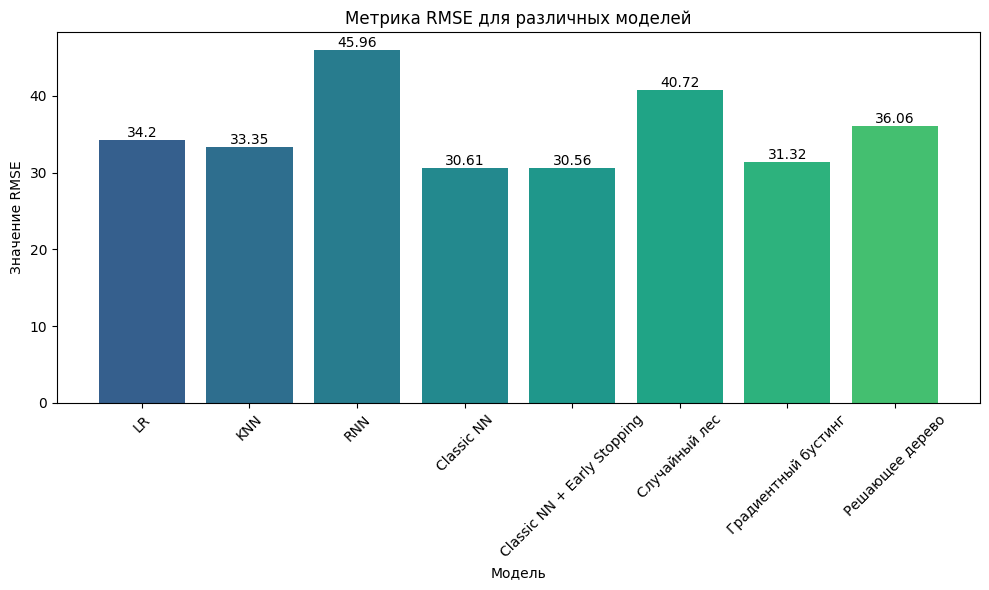

In [ ]:
x = ['LR', 'KNN', 'RNN', 'Classic NN', 'Classic NN + Early Stopping',  'Случайный лес', 'Градиентный бустинг', 'Решающее дерево']
y = [np.sqrt(mean_squared_error(linear_pred, y_valid)), np.sqrt(mean_squared_error(knn_pred, y_valid)), np.sqrt(mean_squared_error(rnn_pred, y_valid_tensor.cpu().numpy())), np.sqrt(mean_squared_error(nn_pred, y_valid)), np.sqrt(mean_squared_error(esnn_pred, y_valid)), np.sqrt(mean_squared_error(rfc_pred, y_valid)), np.sqrt(mean_squared_error(cbr_pred, y_valid)), np.sqrt(mean_squared_error(dtc_pred, y_valid))]



plt.figure(figsize=(10, 6))
bars = plt.bar(x, y, color=plt.cm.viridis(np.linspace(0.3, 0.7, len(y))))

plt.title('Метрика RMSE для различных моделей')
plt.xlabel('Модель')
plt.ylabel('Значение RMSE')
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Как видим, нейронная сеть + early stopping превосходит другие методы, что показывает его эффективность в задачах временных рядов.

Проведем тест моделей на тестовом датасете, чтобы полностью убедится в наших моделях.

In [ ]:
test_pred_dt = dtc_model.predict(X_test)
test_pred_rfc = rfc_model.predict(X_test)
test_pred_cbr = cbr_model.predict(X_test)
test_pred_lr = model_linear.predict(X_test_norm)
test_pred_knn = model_knn.predict(X_test)


with torch.no_grad():
    nn_pred = nn_model(X_t.to(device)).cpu().numpy()

with torch.no_grad():
    esnn_pred = esnn_model(X_t.to(device)).cpu().numpy()


with torch.no_grad():
    rnn_pred = rnn_model(X_test_tensor.to(device)).cpu().numpy()





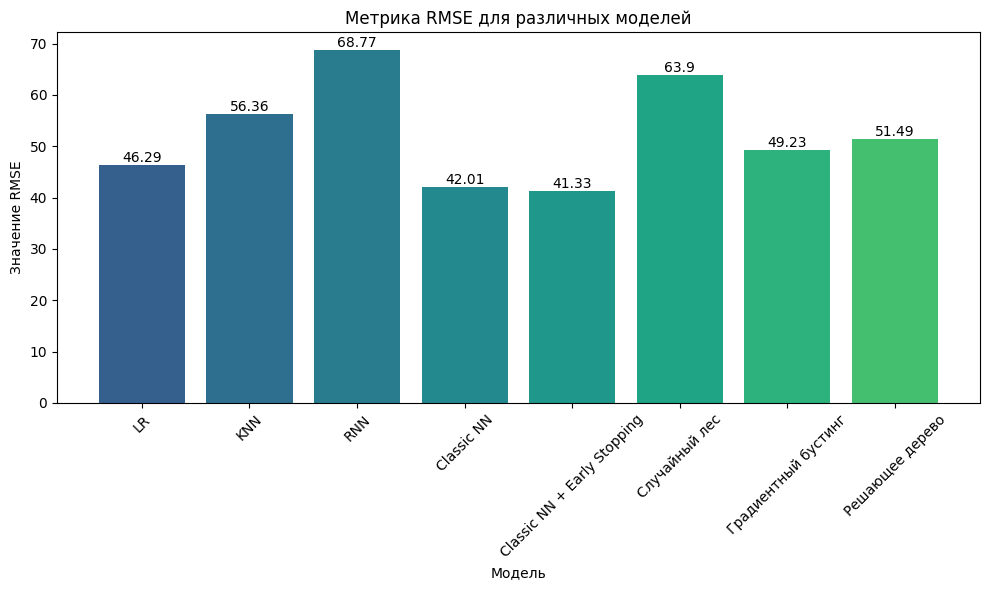

In [ ]:
x = ['LR', 'KNN', 'RNN', 'Classic NN', 'Classic NN + Early Stopping', 'Случайный лес', 'Градиентный бустинг', 'Решающее дерево']
y = [np.sqrt(mean_squared_error(test_pred_lr, y_test)), np.sqrt(mean_squared_error(test_pred_knn, y_test)), np.sqrt(mean_squared_error(rnn_pred, y_test_tensor.cpu().numpy())), np.sqrt(mean_squared_error(nn_pred, y_test)), np.sqrt(mean_squared_error(esnn_pred, y_test)), np.sqrt(mean_squared_error(test_pred_rfc, y_test)), np.sqrt(mean_squared_error(test_pred_cbr, y_test)), np.sqrt(mean_squared_error(test_pred_dt, y_test))]



plt.figure(figsize=(10, 6))
bars = plt.bar(x, y, color=plt.cm.viridis(np.linspace(0.3, 0.7, len(y))))

plt.title('Метрика RMSE для различных моделей')
plt.xlabel('Модель')
plt.ylabel('Значение RMSE')
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Конечно, прочие результаты не такие высокие как бы хотелось, тем более наша задача добиться RMSE < 48, но нейронная сеть + ранней остановкой полностью покрывает нашу задачу и решает ее, эту модель и выберем за счет метрики на валидации. Интересно, что линейная регрессия единственная модель классического машинного обучения, которая бы решила нашу задачу.

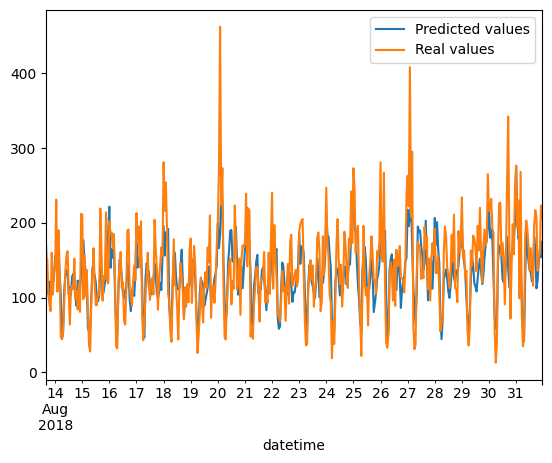

In [ ]:
y_pred = pd.Series(esnn_pred.flatten(), index=y_test.index)
y_pred.plot(label='Predicted values')
y_test.plot(label='Real values')
plt.legend()

Не слишком информативно, но различия есть.

<Axes: xlabel='datetime'>

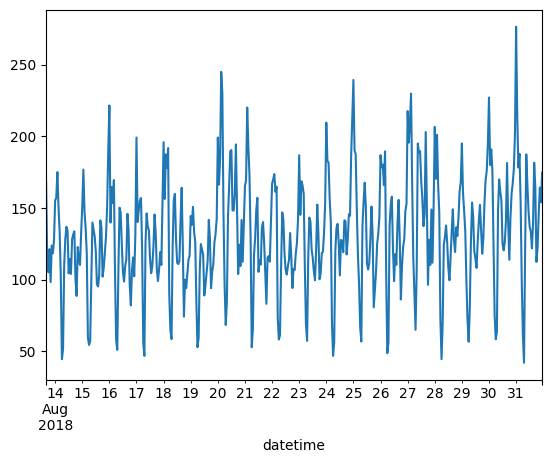

In [ ]:
y_pred.plot()


<Axes: xlabel='datetime'>

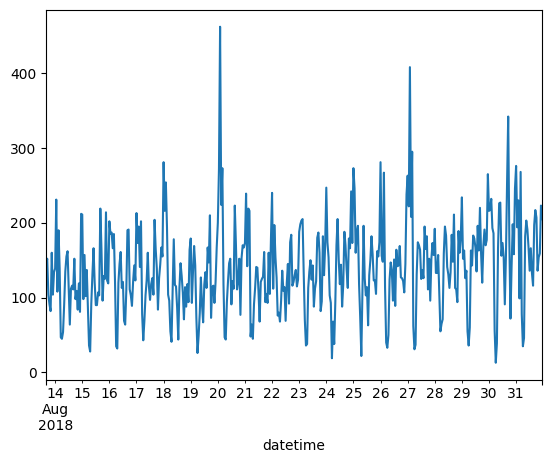

In [ ]:
y_test.plot()

## Вывод

Нашей задачей стало предсказание спроса на такси из аэропорта для временного ряда, цель - разработать модель, которая могла бы добиться RMSE <48 на тестовой выборке. Дан датасет состоящий из количества, заказанного такси для каждый 10 минут.


Во время предобработки изменили временной ряд для одного часа, а не 10 минут. Выделены новые признаки (скользящее среднее, кол-во заказов четыре, три, два, один час назад, год, день недели, час).


При анализе обнаружили, что в общем кол-во заказов растет, у заказов есть сезонность (связано с временем суток и спросом в этом время), а также весь шум довольно рандомизирован, что приводит к тому, что данные у нас довольно чистые.


Далее построили несколько моделей, получили первычные результаты на валидации (лучшей моделью оказалась рекуррентная нейронная сеть с значительным перевесом над другими моделями), дальше оказался градиентный бустинг, решающее дерево и обычная нейронная сеть. Простые модели (k ближайших соседей и линейная регрессия показали посредственный результат). Выбрана лучшей моделью именно RNN за счет своего превосходства над другими моделями. В итоге задача решена с неплохим результатом и получили RMSE < 48.